In [2]:
# !pip install graphviz pydotplus
# !pip3 install catboost
!pip install catboost
!pip install scikit-plot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.8 MB/s eta 0:00:00


In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from google.colab import drive
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import export_graphviz, plot_tree
# import graphviz
# import pydotplus
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier, Pool

In [5]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Importação e exploração dos Datasets treino e teste

In [6]:
df_train_original = pd.read_csv('/content/gdrive/MyDrive/flight_delays/flight_delays_train.csv')
df_test_original = pd.read_csv('/content/gdrive/MyDrive/flight_delays/flight_delays_test.csv')
# df_train_original = pd.read_csv('~/Downloads/flight_delays_train.csv')
# df_test_original = pd.read_csv('~/Downloads/flight_delays_test.csv')

- Month, DayofMonth, DayOfWeek
- DepTime – departure time
- UniqueCarrier – code of a company-career
- Origin – flight origin
- Dest – flight destination
- Distance, distance between Origin and Dest airports
- dep_delayed_15min – target

In [ ]:
df_train_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              100000 non-null  object
 1   DayofMonth         100000 non-null  object
 2   DayOfWeek          100000 non-null  object
 3   DepTime            100000 non-null  int64 
 4   UniqueCarrier      100000 non-null  object
 5   Origin             100000 non-null  object
 6   Dest               100000 non-null  object
 7   Distance           100000 non-null  int64 
 8   dep_delayed_15min  100000 non-null  object
dtypes: int64(2), object(7)
memory usage: 6.9+ MB


In [ ]:
df_train_original.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


Inicialmente vamos manter todas as colunas, não parece haver nenhuma "inútil" apenas olhando por alto. Observa-se que o criador da descrição não especificou se ele está considerando o primeiro dia da semana como Segunda ou Domingo, então trataremos como "primeiro dia", ou "terceiro dia" etc ao invés de nomear os dias.

In [7]:
def clean_dataset(df: pd.DataFrame):
  df = df.copy()
  df['Month'] = df['Month'].apply(lambda x: int(x[2:]))
  df['DayofMonth'] = df['DayofMonth'].apply(lambda x: int(x[2:]))
  df['DayOfWeek'] = df['DayOfWeek'].apply(lambda x: int(x[2:]))

  return df

In [8]:
df_train = clean_dataset(df_train_original)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              100000 non-null  int64 
 1   DayofMonth         100000 non-null  int64 
 2   DayOfWeek          100000 non-null  int64 
 3   DepTime            100000 non-null  int64 
 4   UniqueCarrier      100000 non-null  object
 5   Origin             100000 non-null  object
 6   Dest               100000 non-null  object
 7   Distance           100000 non-null  int64 
 8   dep_delayed_15min  100000 non-null  object
dtypes: int64(5), object(4)
memory usage: 6.9+ MB


In [9]:
df_test = clean_dataset(df_test_original)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Month          100000 non-null  int64 
 1   DayofMonth     100000 non-null  int64 
 2   DayOfWeek      100000 non-null  int64 
 3   DepTime        100000 non-null  int64 
 4   UniqueCarrier  100000 non-null  object
 5   Origin         100000 non-null  object
 6   Dest           100000 non-null  object
 7   Distance       100000 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 6.1+ MB


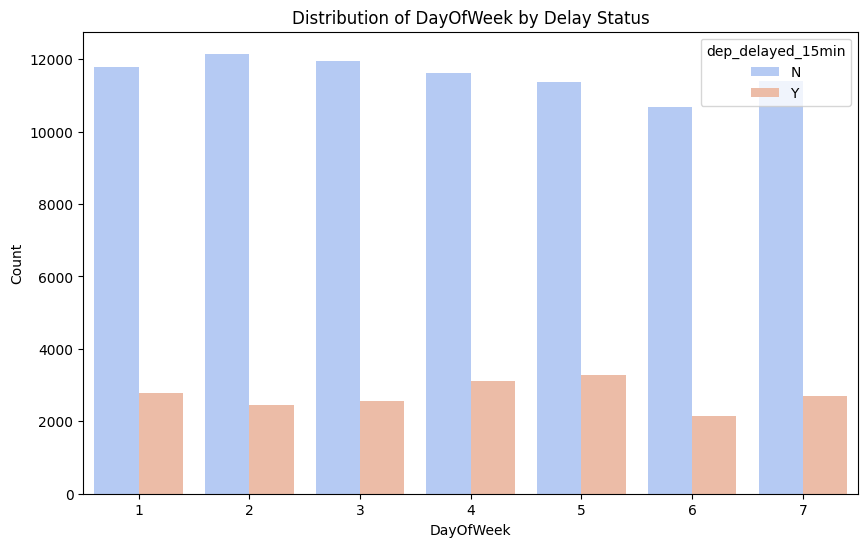

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_train, x='DayOfWeek', hue='dep_delayed_15min', palette='coolwarm')
plt.title(f'Distribution of DayOfWeek by Delay Status')
plt.xlabel('DayOfWeek')
plt.ylabel('Count')
plt.show()

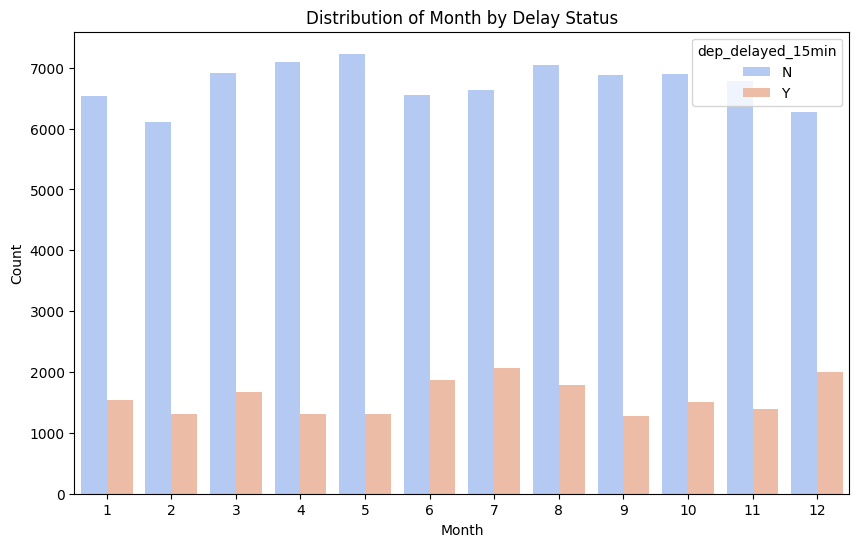

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_train, x='Month', hue='dep_delayed_15min', palette='coolwarm')
plt.title(f'Distribution of Month by Delay Status')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

Visualizamos acima que ocorrem mais atrasos em meses como julho e dezembro, coincidentemente meses de férias

In [ ]:
def dtc_preprocessing(df: pd.DataFrame):
  df = df.copy()

  df['dep_delayed_15min'].replace({'N': 0, 'Y': 1}, inplace=True) if 'dep_delayed_15min' in df.columns else None

  df['DepartureHour'] =  df['DepTime'] // 100
  df['DepartureMinute'] =  df['DepTime'] % 100
  df.drop('DepTime', inplace=True, axis=1)

  df['OriginAndDest'] = df['Origin'] + "_" + df['Dest']
  df['CarrierAndOrigin'] = df['UniqueCarrier'] + "_" + df['Origin']
  df['CarrierAndDest'] = df['UniqueCarrier'] + "_" + df['Dest']

  label_encoders = {}
  for column in ['DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest', 'OriginAndDest', 'CarrierAndOrigin', 'CarrierAndDest']:
    label_encoders[column] = preprocessing.LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])

  return df

In [ ]:
teste = dtc_preprocessing(df_train)
teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   Month              100000 non-null  int64
 1   DayofMonth         100000 non-null  int64
 2   DayOfWeek          100000 non-null  int64
 3   UniqueCarrier      100000 non-null  int64
 4   Origin             100000 non-null  int64
 5   Dest               100000 non-null  int64
 6   Distance           100000 non-null  int64
 7   dep_delayed_15min  100000 non-null  int64
 8   DepartureHour      100000 non-null  int64
 9   DepartureMinute    100000 non-null  int64
 10  OriginAndDest      100000 non-null  int64
 11  CarrierAndOrigin   100000 non-null  int64
 12  CarrierAndDest     100000 non-null  int64
dtypes: int64(13)
memory usage: 9.9 MB


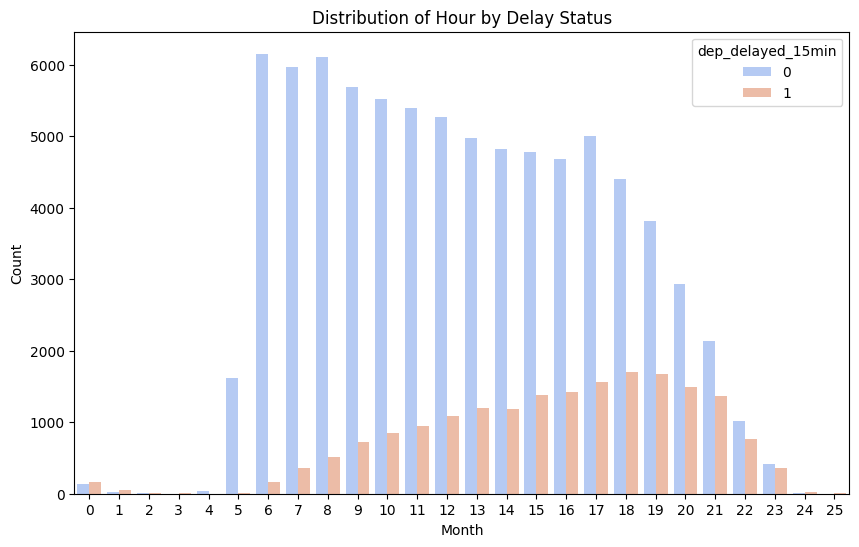

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=dtc_preprocessing(df_train.copy()), x='DepartureHour', hue='dep_delayed_15min', palette='coolwarm')
plt.title(f'Distribution of Hour by Delay Status')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

Vemos no gráfico acima que o possível "horário do rush" da aviação, quando ocorrem mais atrasos, é crescente no decorrer do dia e atinge seu pico nos voos da noite, entre as 18 e 19 horas.

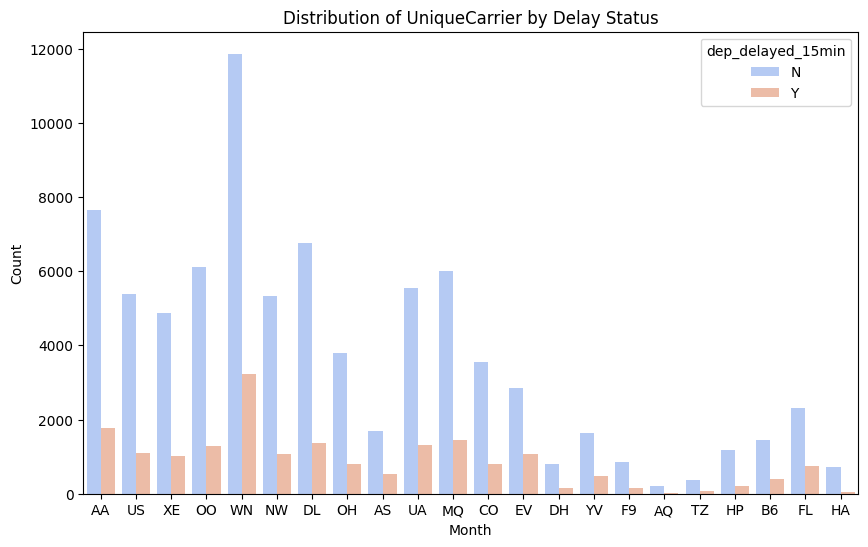

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_train, x='UniqueCarrier', hue='dep_delayed_15min', palette='coolwarm')
plt.title(f'Distribution of UniqueCarrier by Delay Status')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

Através do gráfico acima podemos ver que a empresa aérea com maior proporção de atrasos para cada saída certa é a de sigla EV, enquanto as outras seguem uma proporção parecida de no máximo 1:3

# Decision Tree Classifier

#### Preprocessing

In [ ]:
df_processed = dtc_preprocessing(df_train)

X = df_processed.drop('dep_delayed_15min', axis=1)
y = df_processed['dep_delayed_15min']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)

#### Teste inicial / **ROC-AUC Score: 0.5817**

In [ ]:
# Initialize Decision Tree classifier
clf = DecisionTreeClassifier(random_state=42)

# Fit the model on the training data
clf.fit(X_train, y_train)

# Predict probabilities and compute ROC-AUC score
y_pred_proba = clf.predict_proba(X_test)[:, 1]  # Probability of class 1 (delayed)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'ROC-AUC Score: {roc_auc:.4f}')

ROC-AUC Score: 0.5817


#### Tunando os parametros com GridSearch cross validation / **ROC-AUC Score: 0.6900**

In [ ]:
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

clf = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='roc_auc', verbose=1)


In [ ]:
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f'Best Parameters: {best_params}')


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}


In [ ]:
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probability of class 1 (delayed)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'ROC-AUC Score on Test Set: {roc_auc:.4f}')


ROC-AUC Score on Test Set: 0.6900


Tivemos um incremento na pontuação roc_auc usando GridSearch para tunar os parametros

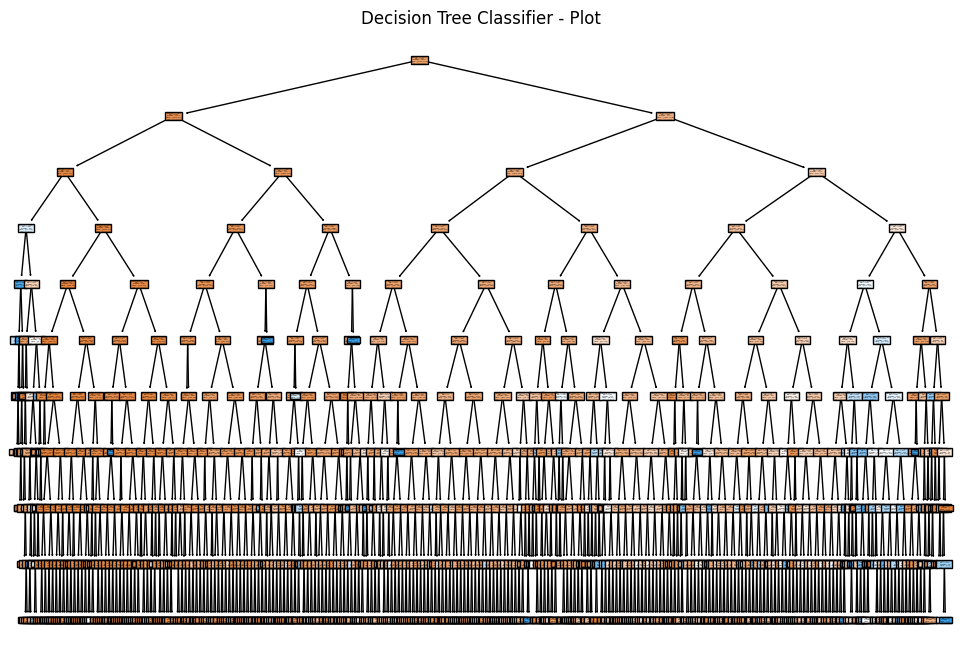

In [ ]:
plt.figure(figsize=(12, 8))
plot_tree(best_model, filled=True, feature_names=X.columns, class_names=['Not Delayed', 'Delayed'])
plt.title("Decision Tree Classifier - Plot")
plt.show()

# Random Forest

#### Preprocessing

In [ ]:
df_processed = dtc_preprocessing(df_train)

X = df_processed.drop('dep_delayed_15min', axis=1)
y = df_processed['dep_delayed_15min']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)

#### Teste inicial / **ROC-AUC Score: 0.7388**

In [ ]:
# Initialize Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)

# Fit the model on the training data
rf_clf.fit(X_train, y_train)

# Predict on the test set
# y_pred = rf_clf.predict(X_test)

# Calculate ROC-AUC score
y_pred_proba = rf_clf.predict_proba(X_test)[:, 1]  # Probability of class 1 (delayed)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'ROC-AUC Score: {roc_auc:.4f}')

ROC-AUC Score: 0.7388


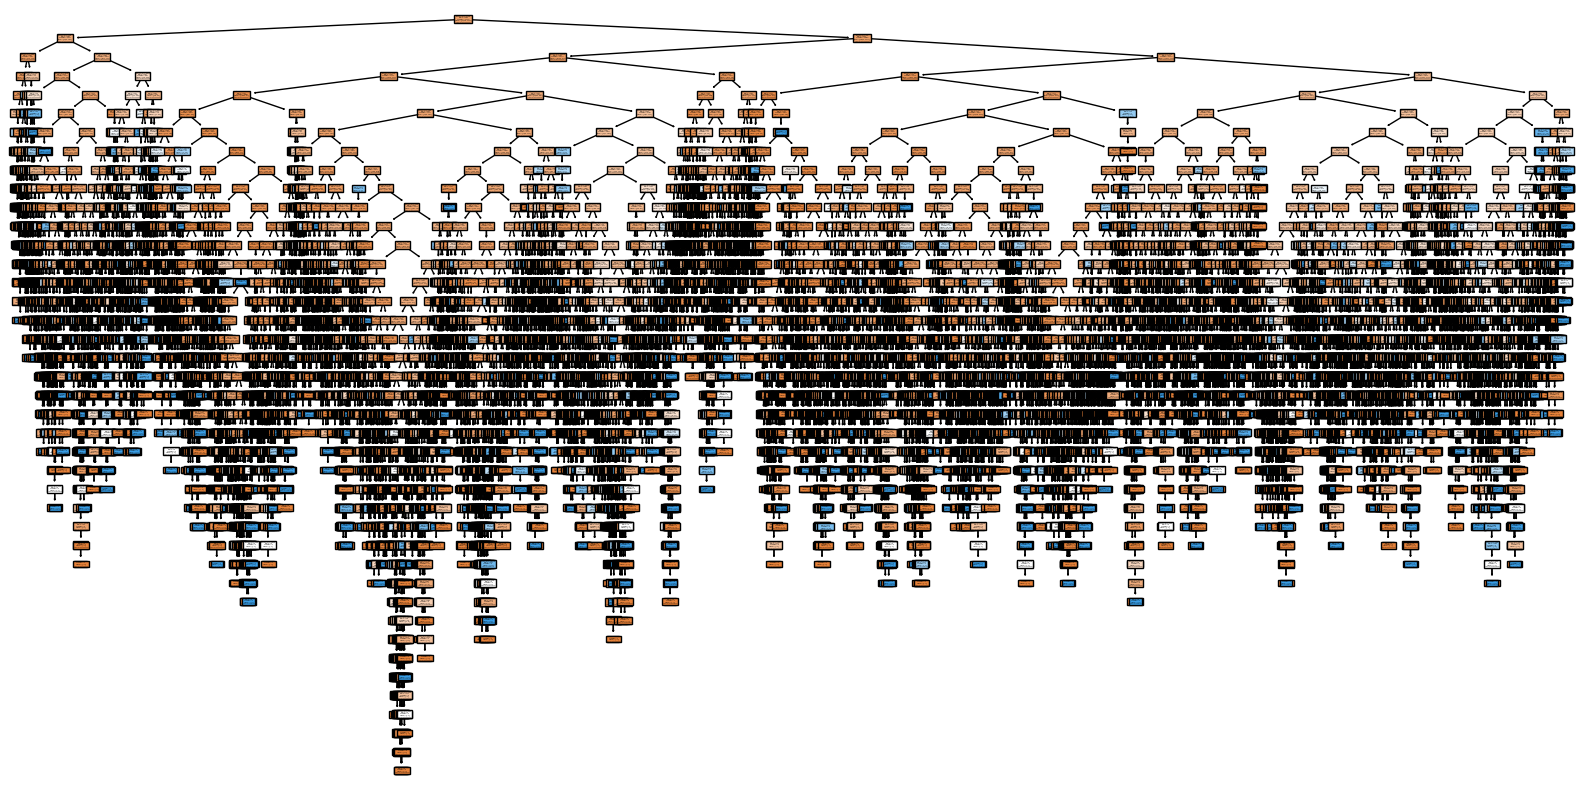

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(rf_clf.estimators_[0], filled=True, feature_names=[f'Feature {i}' for i in range(X.shape[1])], class_names=['Not Delayed', 'Delayed'])
plt.show()

#### Tunando os parametros com GridSearch cross validation / **ROC-AUC Score: 0.7428**

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_clf_gs = RandomForestClassifier(random_state=42)

grid_search_rf = GridSearchCV(rf_clf_gs, param_grid, cv=5, scoring='roc_auc', verbose=1)

In [ ]:
# Fit GridSearchCV
grid_search_rf.fit(X_train, y_train)

# Get the best model
best_rf_clf = grid_search_rf.best_estimator_

# Evaluate the best model
y_pred = best_rf_clf.predict(X_test)
y_pred_proba = best_rf_clf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'Best ROC-AUC Score: {roc_auc:.4f}')
print('\nBest Parameters:')
print(grid_search_rf.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best ROC-AUC Score: 0.7428

Best Parameters:
{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


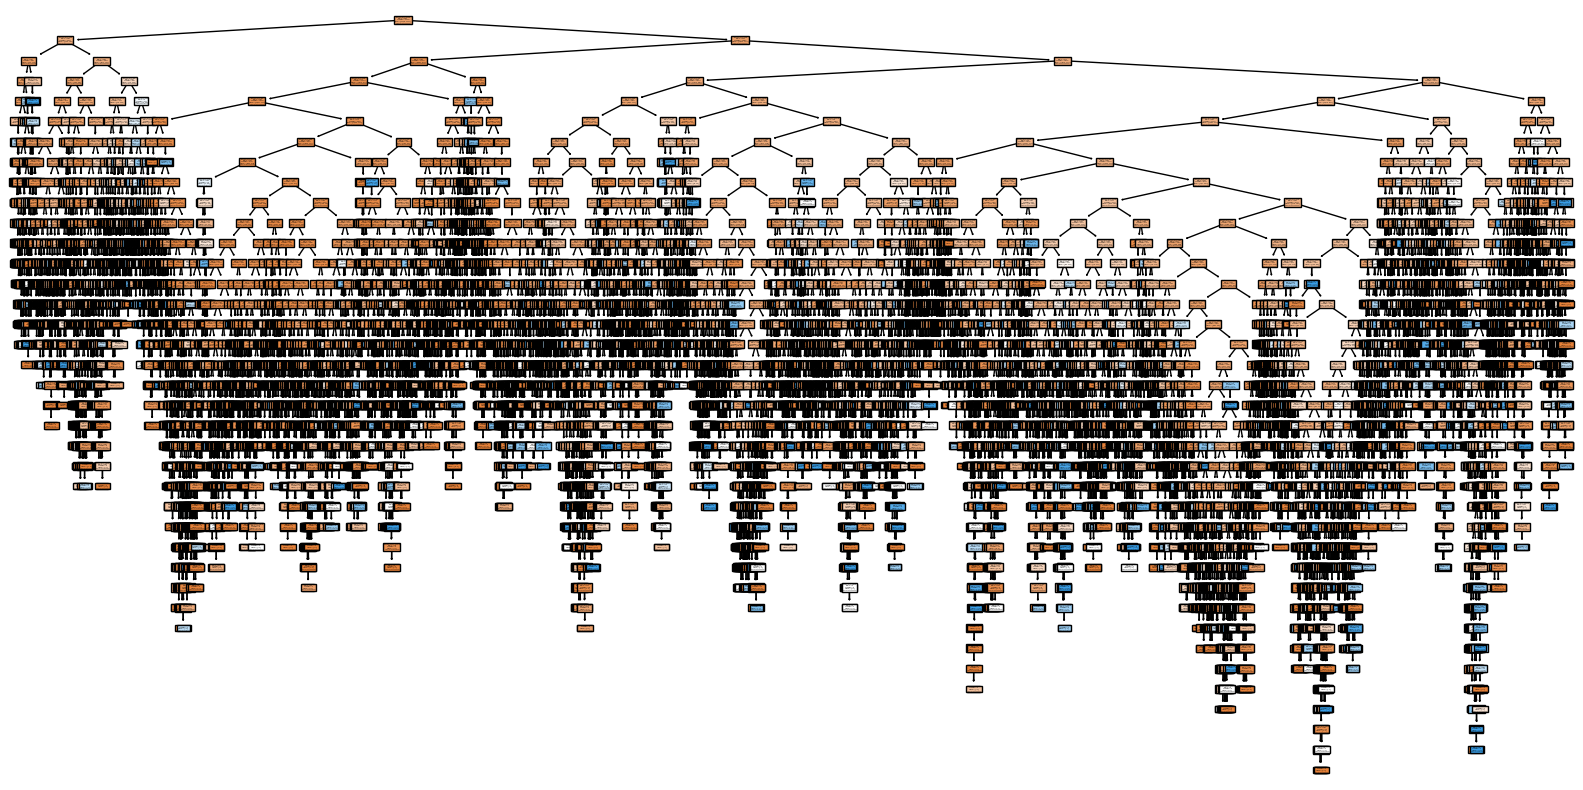

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(best_rf_clf.estimators_[0], filled=True, feature_names=[f'Feature {i}' for i in range(X.shape[1])], class_names=['Not Delayed', 'Delayed'])
plt.show()

# GBDT

#### Preprocessing

In [ ]:
df_processed = dtc_preprocessing(df_train)

X = df_processed.drop('dep_delayed_15min', axis=1)
y = df_processed['dep_delayed_15min']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)

#### Teste inicial / **ROC-AUC Score: 0.7233**

In [ ]:
gb_clf = GradientBoostingClassifier(random_state=42)

gb_clf.fit(X_train, y_train)

y_pred_proba = gb_clf.predict_proba(X_test)[:, 1]  # Probability of class 1 (delayed)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'ROC-AUC Score: {roc_auc:.4f}')

ROC-AUC Score: 0.7233


#### Tunando os parametros com GridSearch cross validation / **ROC-AUC Score: 0.7442**

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# param_grid = {
#     "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
#     "max_depth":[3,5,8],
#     "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
#     "n_estimators":[10, 50, 100, 200]
# }

gb_clf = GradientBoostingClassifier(random_state=42)

grid_search_gb = GridSearchCV(gb_clf, param_grid, cv=5, scoring='roc_auc', verbose=1)

In [ ]:
grid_search_gb.fit(X_train, y_train)
best_gb_clf = grid_search_gb.best_estimator_

y_pred_proba = best_gb_clf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'ROC-AUC Score: {roc_auc:.4f}')
print('\nBest Parameters:')
print(grid_search_gb.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
ROC-AUC Score: 0.7442

Best Parameters:
{'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200}


# CatBoostClassification

#### Preprocessing

In [10]:
def catboost_preprocessing(df: pd.DataFrame):
  df = df.copy()

  df['dep_delayed_15min'].replace({'N': 0, 'Y': 1}, inplace=True) if 'dep_delayed_15min' in df.columns else None

  df['DepartureHour'] =  df['DepTime'] // 100
  # df['DepartureMinute'] =  df['DepTime'] % 100
  # df.drop('DepTime', inplace=True, axis=1)

  df['Route'] = df['Origin'] + "_" + df['Dest']
  df['CarrierAndOrigin'] = df['UniqueCarrier'] + "_" + df['Origin']
  df['CarrierAndDest'] = df['UniqueCarrier'] + "_" + df['Dest']
  df['CarrierAndHour'] = df['UniqueCarrier'] + "_" + df['DepartureHour'].astype('str')
  df['RouteAndHour'] = df['Route'] + "_" + df['DepartureHour'].astype('str')
  df['DepartureHour'] = df['DepartureHour'].astype('str')
  df['CarrierAndDistance'] = df['UniqueCarrier'] + "_" + df['Distance'].astype('str')

  return df

Para usar o CatBoostingClassification não é necessário converter dados categóricos em numéricos, já que o CatBoost lida com isso sozinho

In [11]:
df_train_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              100000 non-null  object
 1   DayofMonth         100000 non-null  object
 2   DayOfWeek          100000 non-null  object
 3   DepTime            100000 non-null  int64 
 4   UniqueCarrier      100000 non-null  object
 5   Origin             100000 non-null  object
 6   Dest               100000 non-null  object
 7   Distance           100000 non-null  int64 
 8   dep_delayed_15min  100000 non-null  object
dtypes: int64(2), object(7)
memory usage: 6.9+ MB


In [12]:
df_train_original.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [13]:
df_train_cb = catboost_preprocessing(df_train_original)
df_train_cb.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,DepartureHour,Route,CarrierAndOrigin,CarrierAndDest,CarrierAndHour,RouteAndHour,CarrierAndDistance
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,0,19,ATL_DFW,AA_ATL,AA_DFW,AA_19,ATL_DFW_19,AA_732
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,0,15,PIT_MCO,US_PIT,US_MCO,US_15,PIT_MCO_15,US_834
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,0,14,RDU_CLE,XE_RDU,XE_CLE,XE_14,RDU_CLE_14,XE_416
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,0,10,DEN_MEM,OO_DEN,OO_MEM,OO_10,DEN_MEM_10,OO_872
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,1,18,MDW_OMA,WN_MDW,WN_OMA,WN_18,MDW_OMA_18,WN_423


In [14]:
df_train_cb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Month               100000 non-null  object
 1   DayofMonth          100000 non-null  object
 2   DayOfWeek           100000 non-null  object
 3   DepTime             100000 non-null  int64 
 4   UniqueCarrier       100000 non-null  object
 5   Origin              100000 non-null  object
 6   Dest                100000 non-null  object
 7   Distance            100000 non-null  int64 
 8   dep_delayed_15min   100000 non-null  int64 
 9   DepartureHour       100000 non-null  object
 10  Route               100000 non-null  object
 11  CarrierAndOrigin    100000 non-null  object
 12  CarrierAndDest      100000 non-null  object
 13  CarrierAndHour      100000 non-null  object
 14  RouteAndHour        100000 non-null  object
 15  CarrierAndDistance  100000 non-null  object
dtypes: 

In [15]:
X = df_train_cb.drop('dep_delayed_15min', axis=1)
y = df_train_cb['dep_delayed_15min']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=33)

#### Teste inicial / ROC-AUC Score: 0.7925

In [16]:
cat_features = ['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest','DepartureHour', 'Route', 'CarrierAndOrigin', 'CarrierAndDest','CarrierAndHour', 'RouteAndHour', 'CarrierAndDistance']
catboost_clf = CatBoostClassifier(eval_metric='AUC', cat_features=cat_features, early_stopping_rounds=20)

# Fit the model on the training data
catboost_clf.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

Learning rate set to 0.093535
0:	test: 0.6664220	best: 0.6664220 (0)	total: 229ms	remaining: 3m 48s
1:	test: 0.6916845	best: 0.6916845 (1)	total: 373ms	remaining: 3m 6s
2:	test: 0.7005114	best: 0.7005114 (2)	total: 539ms	remaining: 2m 59s
3:	test: 0.7103280	best: 0.7103280 (3)	total: 887ms	remaining: 3m 40s
4:	test: 0.7112038	best: 0.7112038 (4)	total: 1.15s	remaining: 3m 49s
5:	test: 0.7112661	best: 0.7112661 (5)	total: 1.48s	remaining: 4m 5s
6:	test: 0.7177909	best: 0.7177909 (6)	total: 1.99s	remaining: 4m 41s
7:	test: 0.7167546	best: 0.7177909 (6)	total: 2.42s	remaining: 4m 59s
8:	test: 0.7154550	best: 0.7177909 (6)	total: 3s	remaining: 5m 30s
9:	test: 0.7174875	best: 0.7177909 (6)	total: 3.5s	remaining: 5m 46s
10:	test: 0.7199237	best: 0.7199237 (10)	total: 4.16s	remaining: 6m 14s
11:	test: 0.7216455	best: 0.7216455 (11)	total: 4.84s	remaining: 6m 38s
12:	test: 0.7219167	best: 0.7219167 (12)	total: 5.25s	remaining: 6m 38s
13:	test: 0.7281725	best: 0.7281725 (13)	total: 5.83s	remain

In [58]:
# Predict on the test set
# y_pred = catboost_clf.predict(X_test)
y_pred_proba = catboost_clf.predict_proba(X_test)[:, 1]  # Probability of class 1 (delayed)

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC-AUC Score: {roc_auc:.4f}')

ROC-AUC Score: 0.7925


#### Curva ROC

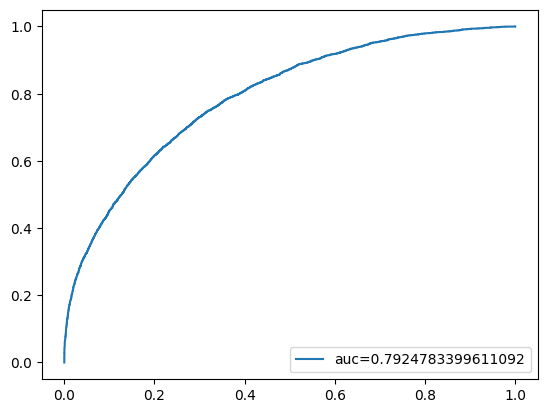

In [59]:
# import scikitplot as skplt
import matplotlib.pyplot as plt

# print(y_test)
# y_pred_proba

fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.show()

# Run final para avaliação do Kaggle

In [60]:
df_test_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Month          100000 non-null  object
 1   DayofMonth     100000 non-null  object
 2   DayOfWeek      100000 non-null  object
 3   DepTime        100000 non-null  int64 
 4   UniqueCarrier  100000 non-null  object
 5   Origin         100000 non-null  object
 6   Dest           100000 non-null  object
 7   Distance       100000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 6.1+ MB


In [61]:
df_test_processed = catboost_preprocessing(df_test_original)
df_test_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Month               100000 non-null  object
 1   DayofMonth          100000 non-null  object
 2   DayOfWeek           100000 non-null  object
 3   DepTime             100000 non-null  int64 
 4   UniqueCarrier       100000 non-null  object
 5   Origin              100000 non-null  object
 6   Dest                100000 non-null  object
 7   Distance            100000 non-null  int64 
 8   DepartureHour       100000 non-null  object
 9   Route               100000 non-null  object
 10  CarrierAndOrigin    100000 non-null  object
 11  CarrierAndDest      100000 non-null  object
 12  CarrierAndHour      100000 non-null  object
 13  RouteAndHour        100000 non-null  object
 14  CarrierAndDistance  100000 non-null  object
dtypes: int64(2), object(13)
memory usage: 11.4+ MB


In [62]:
y_pred_proba = catboost_clf.predict_proba(df_test_processed)[:, 1]  # Probability of class 1 (delayed)

In [63]:
len(y_pred_proba)

100000

In [64]:
res = pd.Series(y_pred_proba, name='dep_delayed_15min')
res.head()

0    0.010626
1    0.028549
2    0.033997
3    0.349574
4    0.355114
Name: dep_delayed_15min, dtype: float64

In [65]:
res.info()

<class 'pandas.core.series.Series'>
RangeIndex: 100000 entries, 0 to 99999
Series name: dep_delayed_15min
Non-Null Count   Dtype  
--------------   -----  
100000 non-null  float64
dtypes: float64(1)
memory usage: 781.4 KB


In [66]:
pd.Series(y_pred_proba, name='dep_delayed_15min').to_csv('lhcc.csv', index_label='id', header=True)

#### Resultado do Kaggle: 0.73902

Um score roc-auc de 0.73902 aponta que o modelo tem aprox 73.902% de chance de prever uma instancia aleatoria "positiva" corretamente. Na base de treinamento, fazendo holdout e testando com uma porcentagem dos dados de treino, o melhor resultado foi 0.7925, que equivale a aproximadamente 4/5 de probabilidade para essa base. O resultado de treinamento não aponta um possível overfitting e isso foi provado com o resultado de testes que não ficou longe do resultado de treino (apesar de mais baixo), mostrando que foi possível treinar um modelo generalista.